In [19]:
import os
import inspect
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import torch
import scanpy as sc
from tqdm import tqdm
import sys
import pickle
import PyComplexHeatmap as pch
import scvi
import IPython
import pandas as pd
import scipy
import numpy as np
import itertools
import xarray as xr
from scipy import sparse
from scipy.stats import rankdata

sc.settings.figdir=os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/analysis/de_mts/gradients')
sc._settings.settings._vector_friendly=True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("GPU is available")
    print("Number of GPUs:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available")

sys.path.append('/home/matthew.schmitz/utils/mts-utils/')
from genomics import sc_analysis


import antipode

gs1=matplotlib.colors.ListedColormap(sc.pl.palettes.godsnot_102,name='godsnot_102')
try:
    matplotlib.colormaps.register(name='godsnot_102',cmap=gs1)
except:
    pass


GPU is not available


In [2]:
table_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/anno_tables/RNA'

In [3]:
batch_key='load_name'
species_key='organism'
donor_key='donor_id'
layer_key=None
leaf_key='Group_propagated'
MDE_KEY = "X_umap_species_integrated"
sex_key = "self_reported_sex"

In [4]:
adata = sc.read("/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/xspecies/BasalGanglia/HMBA_Human_Macaque_Marmoset_Mouse_snRNA-seq_BG_neuron_alignment_labeltransfer_allgenes.h5ad")

In [5]:
adata.obs[species_key] = adata.obs[species_key].astype('category')
species_colors = {'Human':'#377eb8','Macaque':'#4daf4a','Marmoset':'#FF5F5D','Mouse':'#ffa300'}
adata.uns[f'{species_key}_colors'] = [species_colors[x] for x in adata.obs[species_key].cat.categories]

In [6]:
groups = pd.read_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/BasalGanglia_paper_package/anno_tables/consensus_annotation_groups.tsv',header=None)[0]
groups = groups[groups.isin(adata.obs[leaf_key].unique())]
adata.obs[leaf_key] = adata.obs[leaf_key].cat.reorder_categories(groups)

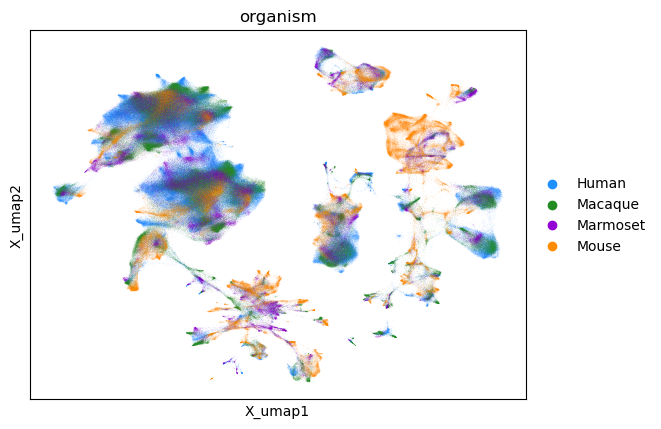

In [7]:
sc.pl.embedding(adata,color=species_key,basis='X_umap')

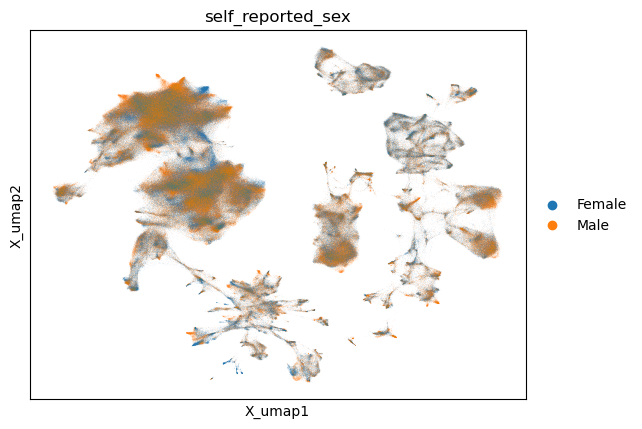

In [8]:
sc.pl.embedding(adata,color=sex_key,basis='X_umap')

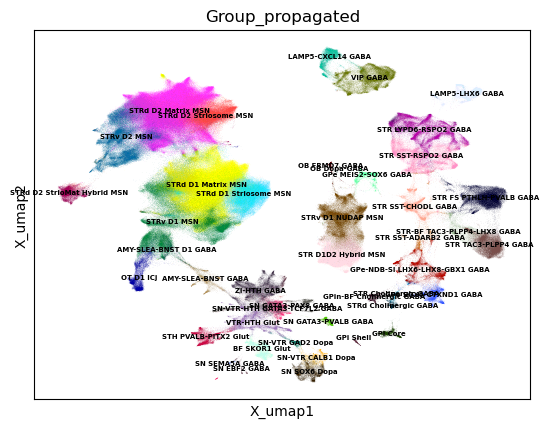

In [9]:
sc.pl.embedding(adata,color=leaf_key,basis='X_umap',legend_loc='on data',legend_fontsize=5)

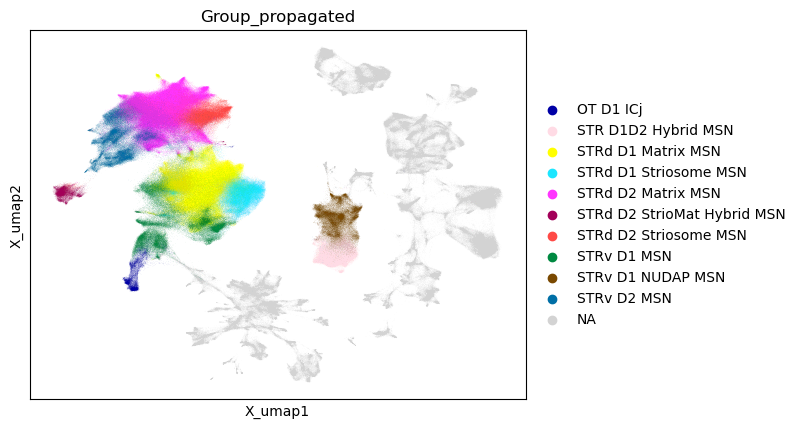

In [10]:
sc.pl.embedding(adata,color=leaf_key,basis='X_umap',groups=list(adata.obs[leaf_key].cat.categories[adata.obs[leaf_key].cat.categories.str.contains('MSN|ICj')]))

In [13]:
if not os.path.exists(os.path.join(table_dir, "species_group_means_hqrm.netcdf")):
    # Get real means and xero proportions
    log_real_means,real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,species_key,leaf_key,layer=layer_key)
    real_means=pd.DataFrame(log_real_means.mean(0),columns=adata.var.index,index=real_mean_levels[leaf_key])
    real_means=real_means.loc[real_mean_levels[leaf_key],:]
    aggr_zeros=antipode.model_functions.group_aggr_anndata(adata,[species_key,leaf_key],layer=layer_key,agg_func=antipode.model_functions.prop_zeros,normalize=True)
    
    coords = {species_key:list(adata.obs[species_key].cat.categories),leaf_key:list(adata.obs[leaf_key].cat.categories),'var':list(adata.var.index.astype(str))}
    lrm = xr.DataArray(log_real_means,coords=coords)
    az = xr.DataArray(aggr_zeros[0],coords=coords)
    ads = xr.Dataset({'scalars':lrm,'proportions':az})
    ads.to_netcdf(os.path.join(table_dir, "species_group_means_hqrm.netcdf"), engine="scipy")
else:
    ads = xr.open_dataset(os.path.join(table_dir, "species_group_means_hqrm.netcdf"), engine="scipy")

In [23]:
gradient_genes = ['TESPA1','CNR1','ST6GALNAC5','GDA','CRYM','WFS1','ARHGAP6','PPP1R1B']#,'ST6GALNAC5','GDA','CRYM','WFS1','ARHGAP6','PPP1R1B']
gradient_genes = [x for x in gradient_genes]

In [15]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

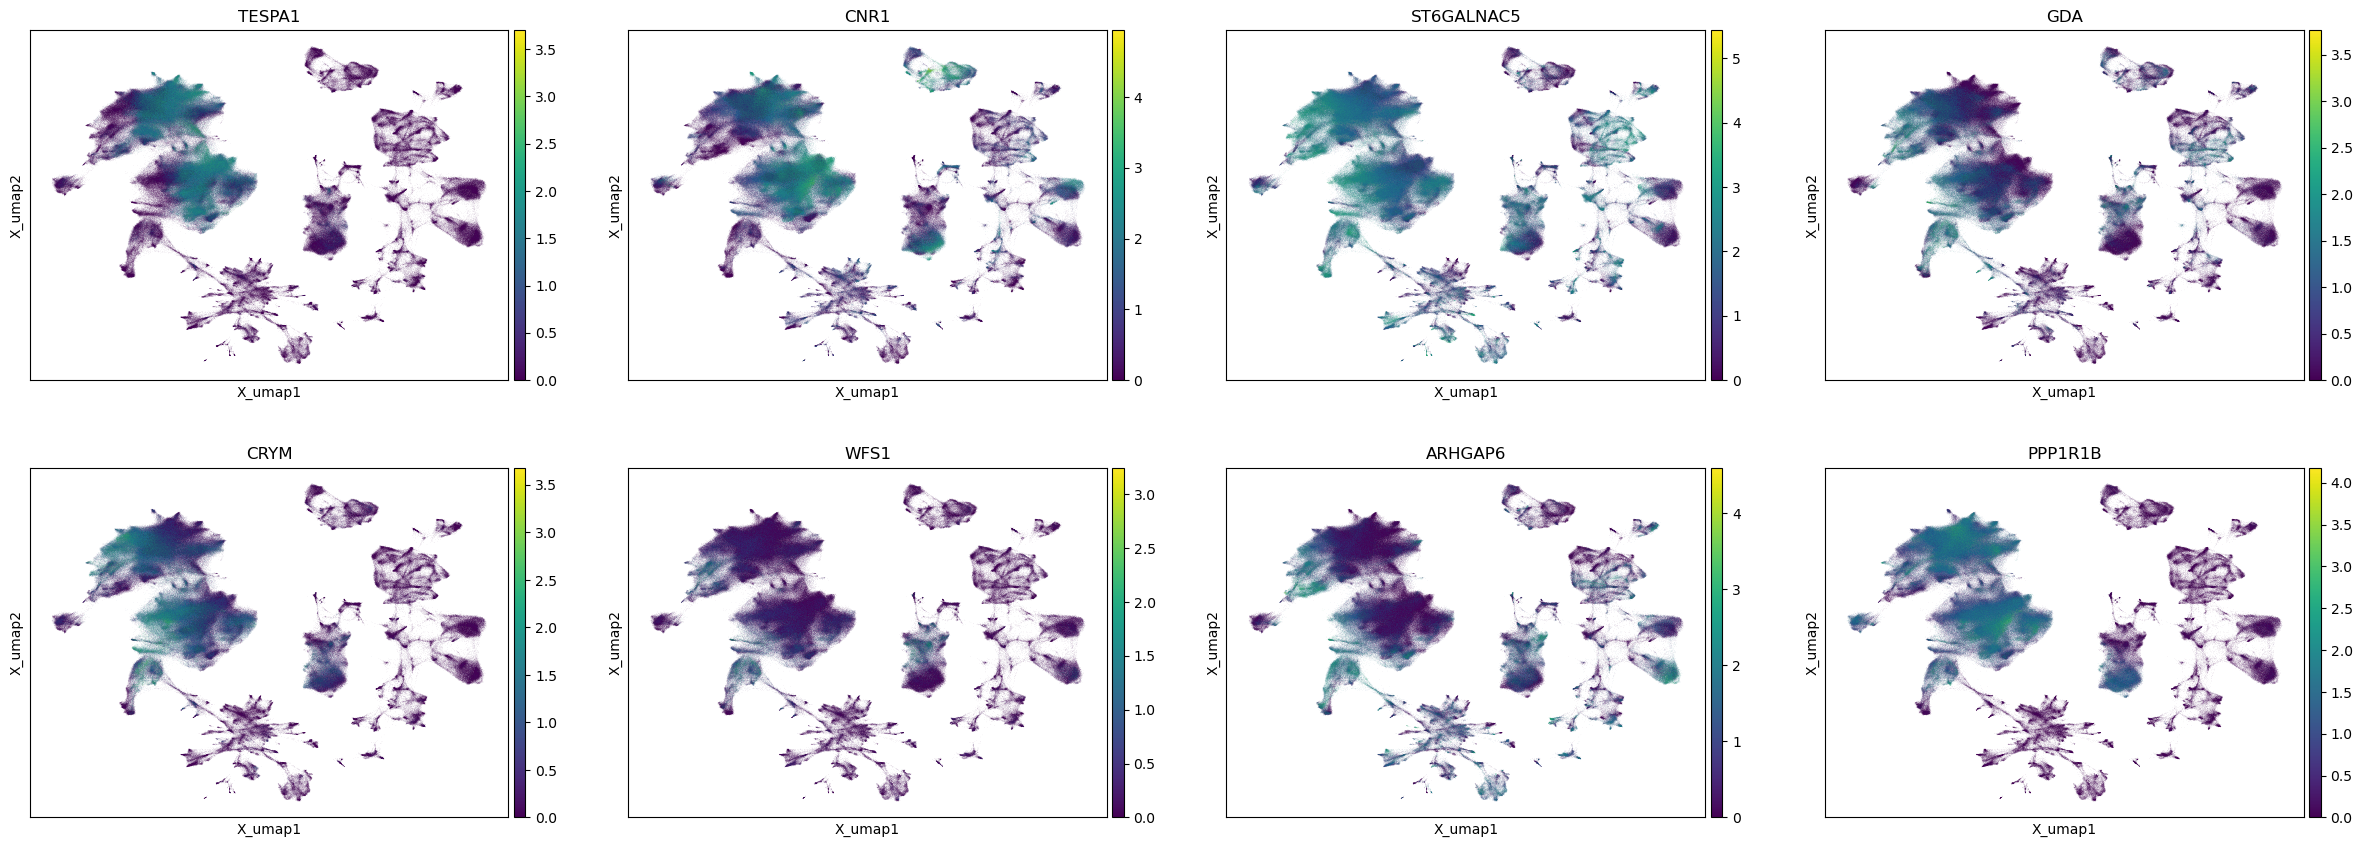

In [24]:
sc.pl.embedding(adata,color=gradient_genes,basis='X_umap')

In [26]:
def correlate_genes(adata, genes_of_interest, layer=None, method="pearson", chunk_size=None, rank_method="average"):
    X = adata.layers[layer] if layer else adata.X
    if not len(genes_of_interest):
        raise ValueError("genes_of_interest is empty")

    goi = [g for g in genes_of_interest if g in adata.var_names]
    if not goi:
        raise ValueError("No genes_of_interest found in adata.var_names")

    n, g = X.shape
    corr_df = pd.DataFrame(index=adata.var_names, columns=goi, dtype=float)

    if method not in ("pearson", "spearman"):
        raise ValueError("method must be 'pearson' or 'spearman'")

    if method == "pearson":
        if sparse.issparse(X):
            X = X.tocsr()
            s = np.asarray(X.sum(axis=0)).ravel()
            ss = np.asarray(X.power(2).sum(axis=0)).ravel()
        else:
            s = X.sum(axis=0)
            ss = (X * X).sum(axis=0)

        mu = s / n
        var = ss - n * mu**2
        std = np.sqrt(np.maximum(var, 0.0))

        for gname in tqdm(goi, desc="Correlating genes (pearson)"):
            gi = adata.var_names.get_loc(gname)
            xg = X[:, gi].toarray().ravel() if sparse.issparse(X) else X[:, gi]

            s_i = xg.sum()
            ss_i = (xg ** 2).sum()
            mu_i = s_i / n
            var_i = ss_i - n * mu_i**2
            std_i = np.sqrt(max(var_i, 0.0))

            if sparse.issparse(X):
                dots = np.asarray(X.T @ xg).ravel()
            else:
                dots = X.T @ xg

            cov = dots - n * mu * mu_i
            corr = np.divide(cov, std * std_i, out=np.zeros_like(cov), where=(std * std_i) != 0)
            corr_df[gname] = corr

        return corr_df

    # Spearman: Pearson on rank-transformed data, computed in chunks to be memory-safe
    if chunk_size is None:
        chunk_size = 2048 if sparse.issparse(X) else g

    def rank_cols(A, method=rank_method):
        R = np.empty_like(A, dtype=float)
        for j in range(A.shape[1]):
            R[:, j] = rankdata(A[:, j], method=method)
        return R

    for gname in tqdm(goi, desc="Correlating genes (spearman)"):
        gi = adata.var_names.get_loc(gname)
        xg = X[:, gi].toarray().ravel() if sparse.issparse(X) else X[:, gi]
        rg = rankdata(xg, method=rank_method)

        # use unnormalized moments (match Rc path)
        s_i = rg.sum()
        ss_i = (rg * rg).sum()
        mu_i = s_i / n
        var_i = ss_i - n * mu_i**2
        std_i = np.sqrt(max(var_i, 0.0))
        if std_i == 0:
            corr_df[gname] = 0.0
            continue

        rg_centered = rg - mu_i
        out = np.zeros(g, dtype=float)

        for start in range(0, g, chunk_size):
            stop = min(start + chunk_size, g)
            Xc = X[:, start:stop].toarray() if sparse.issparse(X) else np.asarray(X[:, start:stop])
            Rc = rank_cols(Xc)

            s = Rc.sum(axis=0)
            ss = (Rc * Rc).sum(axis=0)
            mu = s / n
            var = ss - n * mu**2
            std = np.sqrt(np.maximum(var, 0.0))

            # cov = (Rc - mu)^T @ (rg - mu_i) = Rc^T @ rg_centered (since sum(rg_centered)=0)
            dots = Rc.T @ rg_centered
            denom = std * std_i
            out[start:stop] = np.divide(dots, denom, out=np.zeros_like(dots), where=denom != 0)

        corr_df[gname] = out

    return corr_df


for s in adata.obs['organism'].unique():
    corr_df = correlate_genes(adata[adata.obs[leaf_key].isin(msn_groups)&(adata.obs['organism']==s),:], gradient_genes, method="spearman")
    corr_df.to_csv((os.path.join(sc.settings.figdir, f'{s}_spatial_genes_corr.csv')))

Correlating genes (spearman): 100%|██████████| 8/8 [41:00<00:00, 307.52s/it]


In [27]:
corr_df.sort_values('TESPA1')

,TESPA1,CNR1,ST6GALNAC5,GDA,CRYM,WFS1,ARHGAP6,PPP1R1B
PDE1A,-0.046487,-0.621167,0.130772,0.196159,0.248787,0.270445,0.262256,-0.497332
PDE4D,-0.041305,-0.578022,0.003779,0.187330,0.149321,0.262572,0.321835,-0.486806
CELF4,-0.040672,-0.559727,0.067681,0.173127,0.182354,0.223366,0.248244,-0.432833
PRKG1,-0.033640,-0.559205,0.022336,0.286117,0.303651,0.360396,0.356767,-0.404018
LSAMP,-0.033018,-0.469300,0.125823,0.187144,0.186221,0.235367,0.340320,-0.369531
...,...,...,...,...,...,...,...,...
CNR1,0.044872,1.000000,-0.142097,-0.229856,-0.302019,-0.310101,-0.283269,0.516275
HS6ST3,0.046211,0.714126,-0.124047,-0.192431,-0.258567,-0.299574,-0.266786,0.528117
PDE10A,0.047435,0.699870,-0.115645,-0.153989,-0.190375,-0.283296,-0.249838,0.551131
RBFOX1,0.053301,0.630198,-0.094375,-0.127989,-0.179261,-0.202140,-0.184656,0.413978


In [28]:
corr_df.sort_values('CNR1') #tespa1 is bad in mouse

,TESPA1,CNR1,ST6GALNAC5,GDA,CRYM,WFS1,ARHGAP6,PPP1R1B
PDE1A,-0.046487,-0.621167,0.130772,0.196159,0.248787,0.270445,0.262256,-0.497332
DPP10,-0.024262,-0.593769,0.072640,0.163335,0.183800,0.226291,0.306160,-0.418780
PDE4D,-0.041305,-0.578022,0.003779,0.187330,0.149321,0.262572,0.321835,-0.486806
CELF4,-0.040672,-0.559727,0.067681,0.173127,0.182354,0.223366,0.248244,-0.432833
PRKG1,-0.033640,-0.559205,0.022336,0.286117,0.303651,0.360396,0.356767,-0.404018
...,...,...,...,...,...,...,...,...
CACNB2,0.035254,0.664100,-0.149467,-0.144651,-0.237406,-0.295460,-0.197132,0.440026
ATP2B1,0.038344,0.683376,-0.109303,-0.156949,-0.192993,-0.234635,-0.228420,0.625348
PDE10A,0.047435,0.699870,-0.115645,-0.153989,-0.190375,-0.283296,-0.249838,0.551131
HS6ST3,0.046211,0.714126,-0.124047,-0.192431,-0.258567,-0.299574,-0.266786,0.528117


In [ ]:
gene_order = antipode.post.uniqlist(gradient_genes)
ax,fig = antipode.plotting.pie_dotplot_xr(ads.sel(var=gene_order),row_dim=leaf_key,col_dim='var',slice_dim=species_key,
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

In [11]:
caudate_areas = ['CaH','CaB','CaT']
msn_groups = adata.obs[leaf_key].cat.categories[adata.obs[leaf_key].cat.categories.str.contains('MSN|ICj')]
cadata = adata[adata.obs['anatomical_region'].isin(caudate_areas)&adata.obs[leaf_key].isin(msn_groups),:]
cadata.obs['anatomical_region'] = cadata.obs['anatomical_region'].cat.remove_unused_categories()

/scratch/fast/4210842/ipykernel_3017548/1461215106.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cadata.obs['anatomical_region'] = cadata.obs['anatomical_region'].cat.remove_unused_categories()


In [12]:
aggr_means=antipode.model_functions.group_aggr_anndata(cadata,[species_key,'anatomical_region',leaf_key],layer=layer_key,normalize=True)
aggr_sums=antipode.model_functions.group_aggr_anndata(cadata,[species_key,'anatomical_region',leaf_key],layer=layer_key,normalize=False,agg_func=np.sum)
log_real_means = antipode.model_functions.safe_log_transform(aggr_means[0],aggr_sums[0].sum(-1)[...,np.newaxis])
aggr_zeros=antipode.model_functions.group_aggr_anndata(cadata,[species_key,'anatomical_region',leaf_key],layer=layer_key,agg_func=antipode.model_functions.prop_zeros,normalize=True)

coords = {species_key:list(cadata.obs[species_key].cat.categories),'anatomical_region':list(cadata.obs['anatomical_region'].cat.categories),leaf_key:list(cadata.obs[leaf_key].cat.categories),'var':list(cadata.var.index)}
lrm_prim = xr.DataArray(log_real_means,coords=coords)
az_prim = xr.DataArray(aggr_zeros[0],coords=coords)
cads = xr.Dataset({'scalars':lrm_prim,'proportions':az_prim})

100%|██████████| 60/60 [01:56<00:00,  1.94s/it]


In [ ]:
sc.pl.embedding(cadata,color=leaf_key,basis='X_umap')
sc.pl.embedding(cadata,color='anatomical_region',basis='X_umap')

# abandoned regression based gradient search 

In [ ]:
seg_levels = cads['scalars'].coords['anatomical_region'].values
seg_codes  = np.arange(len(seg_levels), dtype=float)

lrm_num = cads['scalars'].assign_coords(
    anatomical_region=('anatomical_region', seg_codes),
    anatomical_region_label=('anatomical_region', seg_levels)
)

# now this works: fits along the numeric coord
pf = lrm_num.polyfit(dim='anatomical_region', deg=1)

# slope → shape [organism_name, Group, var]
slope = pf.polyfit_coefficients.sel(degree=1).rename('slope')


In [ ]:
import pandas as pd

n = 10
group_col = "Group_propagated"

# species-mean slope per (group, var) → flat DF
df_all = (slope.mean(species_key)
               .to_series()
               .dropna()
               .rename("slope")
               .reset_index())  # cols: [Group_propagated, var, slope]

# top n per group
top = (df_all.sort_values([group_col, "slope"], ascending=[True, False])
             .groupby(group_col, group_keys=False)
             .head(n))
top["kind"] = "top"
top["rank"] = top.groupby(group_col).cumcount()

# bottom n per group
bot = (df_all.sort_values([group_col, "slope"], ascending=[True, True])
             .groupby(group_col, group_keys=False)
             .head(n))
bot["kind"] = "bottom"
bot["rank"] = bot.groupby(group_col).cumcount()

df = pd.concat([top, bot], ignore_index=True)
# df columns: [Group_propagated, var, slope, kind, rank]


In [ ]:
df

In [ ]:
df.loc[df['Group_propagated'].str.contains('D2'),'var'].value_counts()

In [ ]:
df.loc[df['Group_propagated'].str.contains('ybrid|NUDAP'),'var'].value_counts()

In [ ]:
sc.pl.embedding(adata,color=['ID1','APOC1','TAC3','DIO3','GPR139'],basis='X_umap')

In [ ]:
cads

In [ ]:
gene_order = ['APOC1','TAC3','DIO3','VWA1','GPR139']
ax,fig = antipode.plotting.pie_dotplot_xr(cads.mean(species_key).sel(var=gene_order),row_dim=leaf_key,col_dim='var',slice_dim='anatomical_region',
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

In [ ]:
gene_order = ['APOC1','TAC3','P2RX2']
ax,fig = antipode.plotting.pie_dotplot_xr(cads.mean(species_key).sel(var=gene_order),row_dim=leaf_key,col_dim='var',slice_dim='anatomical_region',
      scale_by='column', max_radius=0.4, figsize=(12, 10),fontsize_mul=0.78,x_spacing=.7, y_spacing=1.)
# plt.savefig(os.path.join(sc.settings.figdir, 'triple_conserved_marker_dots.svg'), format='svg')
plt.show()

